In [1]:
# If any of these are missing, uncomment the next line:
# %pip install -q pandas numpy matplotlib pillow

from pathlib import Path
import pandas as pd
import numpy as np
import re, json, math

In [3]:
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 50)

# ---- Paths ----
BASE = Path("/Users/precioux/Desktop/Creativity")
GEMINI_DIR = BASE / "code" / "gemini"

# We will ONLY use the v2 results file you already ran.
RESULTS_JSONL = GEMINI_DIR / "out" / "gemini_all.jsonl"   # <-- no v3

META_CSV   = BASE / "FacesInThings" / "metadata.csv"
IMAGES_DIR = BASE / "FacesInThings" / "images"

print("Results JSONL:", RESULTS_JSONL, "| exists:", RESULTS_JSONL.exists())
print("Metadata CSV :", META_CSV,      "| exists:", META_CSV.exists())
print("Images dir   :", IMAGES_DIR,    "| exists:", IMAGES_DIR.exists())


Results JSONL: /Users/precioux/Desktop/Creativity/code/gemini/out/gemini_all.jsonl | exists: True
Metadata CSV : /Users/precioux/Desktop/Creativity/FacesInThings/metadata.csv | exists: True
Images dir   : /Users/precioux/Desktop/Creativity/FacesInThings/images | exists: True


In [4]:
# ---- Helpers we'll reuse later ----
def base_filename(p: str) -> str:
    try:
        return Path(p).name
    except Exception:
        return str(p)

def detect_image_column(df: pd.DataFrame) -> str:
    cands = [c for c in df.columns if any(k in c.lower() for k in ["image", "file", "filename", "img", "path"])]
    return sorted(cands, key=lambda x: (len(x), x))[0] if cands else ""

def normalize_value(x: str) -> str:
    if x is None or (isinstance(x, float) and math.isnan(x)):
        return ""
    s = str(x).strip().lower()
    s = re.sub(r"\s+", " ", s)
    s = s.replace("_", " ").replace("/", " ").replace("\\", " ")
    s = s.replace("’", "'").replace("–", "-").replace("—", "-")
    s = re.sub(r"[^\w\s-]", "", s)
    s = re.sub(r"\s*-\s*", "-", s)
    synonyms = {
        "yes": "yes", "no": "no", "somewhat": "somewhat",
        "neutral": "neutral", "happy": "happy", "sad": "sad", "other": "other", "unknown": "unknown",
        "male": "male", "female": "female",
        "easy": "easy", "medium": "medium", "hard": "hard",
        "accident": "accident", "design": "design",
        "human-adult": "human-adult", "human adult": "human-adult",
        "cartoon": "cartoon", "animal": "animal", "object": "object", "creature": "creature",
    }
    return synonyms.get(s, s)

EXPECTED_ATTRS = [
    "Hard to spot?",
    "Accident or design?",
    "Emotion?",
    "Person or creature?",
    "Gender?",
    "Amusing?",
]

In [5]:
# STEP 2 — load metadata.csv and inspect columns/labels

from IPython.display import display

# 1) Load metadata
meta = pd.read_csv(META_CSV)
print("metadata.csv shape:", meta.shape)

# 2) Detect the image filename column and create a normalized filename for joining later
img_col = detect_image_column(meta)
if not img_col:
    raise SystemExit("Could not detect an image filename column in metadata.csv (look for columns like image/filename/path).")
meta["_image_file"] = meta[img_col].map(base_filename)

print("Detected image column:", img_col)
print("\nFirst 3 rows:")
display(meta.head(3))

# 3) Quick value counts for the expected attributes (top 12 shown)
print("\nLabel value counts (top 12 each):")
for attr in EXPECTED_ATTRS:
    if attr in meta.columns:
        vc = meta[attr].value_counts(dropna=False).head(12)
        print(f"\n[{attr}]")
        display(vc.to_frame("count"))
    else:
        print(f"\n[{attr}] — column NOT found in metadata")


metadata.csv shape: (4537, 16)
Detected image column: file

First 3 rows:


,file,url,boxes,is_primary,Is there a face?,Hard to spot?,Accident or design?,Emotion?,Person or creature?,Gender?,Amusing?,Common?,Flags,num_boxes,train,split,_image_file
0,000007038.jpg,https://raw.githubusercontent.com/3lbom/pareidolia/main/data/00000/000007038.jpg,"[[202.105, 160.975, 233.308, 190.05]]",[True],Yes,Hard,Accident,Neutral,Animal,Neutral,Somewhat,Uncommon,['Interesting'],1,False,3,000007038.jpg
1,000018844.jpg,https://raw.githubusercontent.com/3lbom/pareidolia/main/data/00001/000018844.jpg,"[[138, 288, 83, 71]]",[True],Yes,Hard,Accident,Neutral,Human-Old,Male,No,Uncommon,NaN,1,True,0,000018844.jpg
2,000026283.jpg,https://raw.githubusercontent.com/3lbom/pareidolia/main/data/00002/000026283.jpg,"[[268, 315, 16, 26], [316, 266, 21, 17]]","[False, True]",Several,Easy,Design,Neutral,Cartoon,Neutral,No,Uncommon,['Interesting'],2,False,1,000026283.jpg



Label value counts (top 12 each):

[Hard to spot?]


,count
Hard to spot?,
Easy,2735
Medium,942
Hard,815
NaN,45



[Accident or design?]


,count
Accident or design?,
Accident,2524
Design,1989
NaN,24



[Emotion?]


,count
Emotion?,
Neutral,2357
Happy,1216
Surprised,317
Scared,268
Angry,160
Sad,151
Disgusted,39
Other,22
NaN,7



[Person or creature?]


,count
Person or creature?,
Animal,1036
Other,759
Human-Adult,729
Cartoon,700
Robot,579
Alien,335
Human-Old,216
Human-Young,169
NaN,14



[Gender?]


,count
Gender?,
Neutral,3647
Male,755
Female,118
NaN,17



[Amusing?]


,count
Amusing?,
No,3215
Somewhat,1090
Yes,224
NaN,8


In [6]:
# STEP 3 — load results JSONL (v2) and sanity check

from IPython.display import display

# 1) Read JSONL safely (skip non-JSON lines)
rows = []
skipped_nonjson = 0
with open(RESULTS_JSONL, "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            rows.append(json.loads(line))
        except json.JSONDecodeError:
            skipped_nonjson += 1

df = pd.DataFrame(rows)
print(f"Parsed rows: {len(df)} | skipped_nonjson: {skipped_nonjson}")

# 2) Ensure we have an image identifier column and add a normalized filename for joining
if "image_path" not in df.columns:
    for c in ["image", "img", "path", "file"]:
        if c in df.columns:
            df["image_path"] = df[c]
            break
if "image_path" not in df.columns:
    raise SystemExit("Results JSONL lacks 'image_path' (or a similar field: image/img/path/file).")

df["_image_file"] = df["image_path"].map(base_filename)

# 3) Quick counts: errors, any 'no_face', and rows that have at least one of the expected attrs
error_lines = int(df["error"].notna().sum()) if "error" in df.columns else 0
noface = int((df.get("no_face") == True).sum()) if "no_face" in df.columns else 0

existing_expected = [c for c in EXPECTED_ATTRS if c in df.columns]
valid_attr_rows = int(df[existing_expected].notna().any(axis=1).sum()) if existing_expected else 0

print(f"Columns (first 12): {list(df.columns)[:12]} ... (total {len(df.columns)})")
print(f"errors: {error_lines} | no_face: {noface} | rows with any expected attrs: {valid_attr_rows}")

# 4) Show a compact preview
to_show = ["_image_file", "image_path", "latency_ms", "model", "error", "no_face"] + existing_expected
to_show = [c for c in to_show if c in df.columns]
display(df[to_show].head(5))


Parsed rows: 4827 | skipped_nonjson: 0
Columns (first 12): ['image_path', 'model', 'error', 'latency_ms', 'Hard to spot?', 'Accident or design?', 'Emotion?', 'Person or creature?', 'Gender?', 'Amusing?', '_raw', '_image_file'] ... (total 12)
errors: 715 | no_face: 0 | rows with any expected attrs: 4112


,_image_file,image_path,latency_ms,model,error,Hard to spot?,Accident or design?,Emotion?,Person or creature?,Gender?,Amusing?
0,000000009.jpg,/Users/precioux/Desktop/Creativity/FacesInThings/images/000000009.jpg,NaN,gemini-2.5-flash-lite,exception:403 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent?%24alt=json%3Benum-encoding%3Dint: <!DOCTYPE html>\n<html lang=en>\n <meta charset...,NaN,NaN,NaN,NaN,NaN,NaN
1,000000027.jpg,/Users/precioux/Desktop/Creativity/FacesInThings/images/000000027.jpg,NaN,gemini-2.5-flash-lite,exception:403 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2.5-flash-lite:generateContent?%24alt=json%3Benum-encoding%3Dint: <!DOCTYPE html>\n<html lang=en>\n <meta charset...,NaN,NaN,NaN,NaN,NaN,NaN
2,000000052.jpg,/Users/precioux/Desktop/Creativity/FacesInThings/images/000000052.jpg,1183.0,gemini-2.5-flash-lite,NaN,Easy,Design,Happy,Cartoon,Neutral,Yes
3,000000060.jpg,/Users/precioux/Desktop/Creativity/FacesInThings/images/000000060.jpg,968.0,gemini-2.5-flash-lite,NaN,Medium,Accident,Neutral,Other,Neutral,Somewhat
4,000000068.jpg,/Users/precioux/Desktop/Creativity/FacesInThings/images/000000068.jpg,919.0,gemini-2.5-flash-lite,NaN,Easy,Design,Neutral,Other,Neutral,Yes


In [7]:
# STEP 4 — join results↔︎metadata and compute per-attribute accuracy

from IPython.display import display

# 1) split out errors safely
if "error" in df.columns:
    mask_err = df["error"].notna() & df["error"].astype(str).str.len().gt(0)
else:
    import pandas as pd
    mask_err = pd.Series(False, index=df.index)

df_good = df.loc[~mask_err].copy()
if df_good.empty or "image_path" not in df_good.columns:
    raise SystemExit("No valid predictions to score (all lines errored or missing image_path).")

df_good["_image_file"] = df_good["image_path"].map(base_filename)

# 2) align metadata attribute columns to our EXPECTED_ATTRS
norm = {re.sub(r"[^\w]+", "", c.lower()): c for c in meta.columns}
colmap = {}
for attr in EXPECTED_ATTRS:
    if attr in meta.columns:
        colmap[attr] = attr
    else:
        key = re.sub(r"[^\w]+", "", attr.lower())
        colmap[attr] = norm.get(key)

# warn if anything missing
missing = [k for k, v in colmap.items() if v is None]
if missing:
    print("WARNING: missing columns in metadata for:", missing)

keep_cols = ["_image_file"] + [c for c in colmap.values() if c is not None]
meta_small = meta[keep_cols].copy()
rename_map = {v: k for k, v in colmap.items() if v is not None}
meta_small = meta_small.rename(columns=rename_map)

# ensure expected columns exist in both frames
for attr in EXPECTED_ATTRS:
    if attr not in meta_small.columns:
        meta_small[attr] = None
    if attr not in df_good.columns:
        df_good[attr] = None

# 3) merge
merged = pd.merge(df_good, meta_small, on="_image_file", how="inner", suffixes=("_pred", "_gt"))
print("Merged shape:", merged.shape)

# 4) per-attribute accuracy
def normalize_value_local(x):
    return normalize_value(x)  # uses helper from Step 1

rows = []
for attr in EXPECTED_ATTRS:
    pred_col = f"{attr}_pred"
    gt_col   = f"{attr}_gt"
    if pred_col not in merged.columns or gt_col not in merged.columns:
        continue
    sub = merged[[pred_col, gt_col]].copy()
    sub["pred_norm"] = sub[pred_col].map(normalize_value_local)
    sub["gt_norm"]   = sub[gt_col].map(normalize_value_local)
    valid = sub[sub["gt_norm"].ne("")]
    total = int(len(valid))
    correct = int((valid["pred_norm"] == valid["gt_norm"]).sum())
    acc = (correct / total) if total else 0.0
    rows.append({"attribute": attr, "n_scored": total, "n_correct": correct, "accuracy": round(acc, 4)})

acc = pd.DataFrame(rows).sort_values("attribute")
print("\n=== Per-attribute accuracy ===")
display(acc)

# 5) peek at a few mismatches for the first attribute
first_attr = acc.iloc[0]["attribute"] if not acc.empty else EXPECTED_ATTRS[0]
pc, gc = f"{first_attr}_pred", f"{first_attr}_gt"
mism = merged[[ "_image_file", pc, gc ]].copy()
mism["pred_norm"] = mism[pc].map(normalize_value_local)
mism["gt_norm"]   = mism[gc].map(normalize_value_local)
mism = mism[(mism["gt_norm"]!="") & (mism["pred_norm"] != mism["gt_norm"])].head(10)

print(f"\nTop mismatches for [{first_attr}] (first 10):")
display(mism)


Merged shape: (3874, 18)

=== Per-attribute accuracy ===


,attribute,n_scored,n_correct,accuracy
1,Accident or design?,3854,3181,0.8254
5,Amusing?,3866,768,0.1987
2,Emotion?,3867,2350,0.6077
4,Gender?,3860,3155,0.8174
0,Hard to spot?,3834,2441,0.6367
3,Person or creature?,3862,1119,0.2897



Top mismatches for [Accident or design?] (first 10):


,_image_file,Accident or design?_pred,Accident or design?_gt,pred_norm,gt_norm
17,000000160.jpg,Design,Accident,design,accident
25,000000220.jpg,Design,Accident,design,accident
30,000000289.jpg,Design,Accident,design,accident
50,000000436.jpg,Accident,Design,accident,design
52,000000445.jpg,Design,Accident,design,accident
53,000000446.jpg,Design,Accident,design,accident
56,000000477.jpg,Design,Accident,design,accident
62,000000544.jpg,Design,Accident,design,accident
63,000000549.jpg,Accident,Design,accident,design
65,000000575.jpg,Design,Accident,design,accident


In [9]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 346.1 kB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 391.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [matplotlib]5 [matplotlib]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


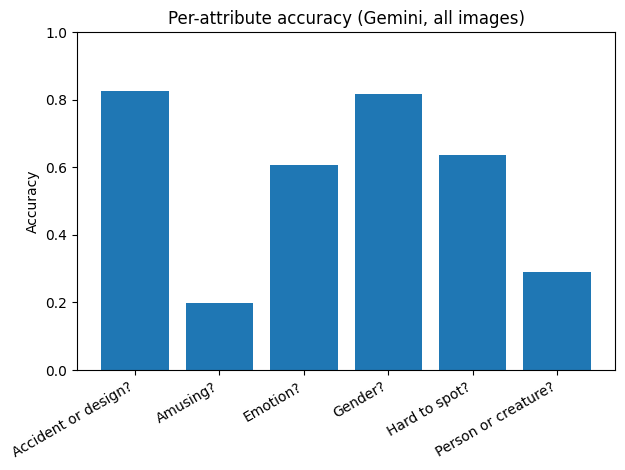

Saved → /Users/precioux/Desktop/Creativity/code/gemini/compare_out/viz/accuracy_bar.png


In [10]:
# STEP 5 — accuracy bar chart (uses `acc` from Step 4)

import matplotlib.pyplot as plt
from pathlib import Path

VIZ_DIR = GEMINI_DIR / "compare_out" / "viz"
VIZ_DIR.mkdir(parents=True, exist_ok=True)

fig = plt.figure()
plt.bar(acc["attribute"], acc["accuracy"])  # default colors, single plot
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=30, ha='right')
plt.title("Per-attribute accuracy (Gemini, all images)")
plt.tight_layout()

out_png = VIZ_DIR / "accuracy_bar.png"
plt.savefig(out_png, dpi=200)
plt.show()

print("Saved →", out_png)


Pred,alien,animal,cartoon,human-adult,human-old,human-young,other,robot
GT,,,,,,,,
,0,1,2,0,1,0,7,1
alien,1,35,16,0,5,0,202,0
animal,0,358,171,3,12,2,325,4
cartoon,0,38,289,3,0,2,281,26
human-adult,2,29,146,18,49,21,335,5
human-old,0,17,5,0,17,0,115,0
human-young,1,5,115,0,0,1,37,0
other,0,63,234,4,5,2,357,4
robot,1,18,73,4,1,0,327,78


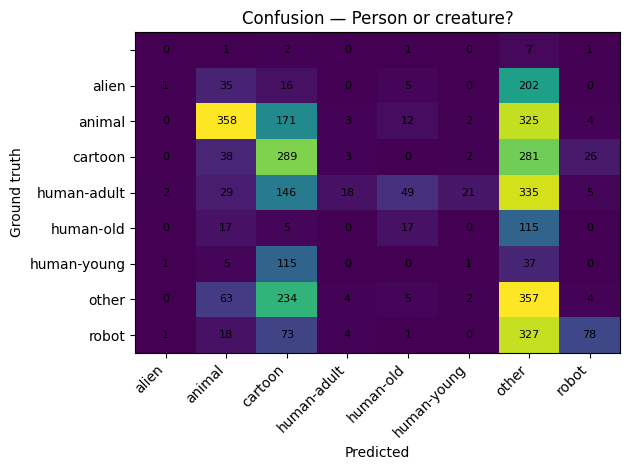

In [15]:
# STEP 6 — confusion matrix for "Person or creature?"

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

attr = "Person or creature?"
pc, gc = f"{attr}_pred", f"{attr}_gt"

sub = merged[[pc, gc]].dropna(how="all").copy()
sub["pred_norm"] = sub[pc].map(normalize_value)
sub["gt_norm"]   = sub[gc].map(normalize_value)

cm = pd.crosstab(sub["gt_norm"], sub["pred_norm"], rownames=["GT"], colnames=["Pred"], dropna=False)
display(cm)

plt.figure()
plt.imshow(cm.values, aspect='auto')
plt.xticks(range(cm.shape[1]), cm.columns, rotation=45, ha='right')
plt.yticks(range(cm.shape[0]), cm.index)
plt.title(f"Confusion — {attr}")
plt.xlabel("Predicted")
plt.ylabel("Ground truth")
for (i, j), val in np.ndenumerate(cm.values):
    plt.text(j, i, int(val), ha='center', va='center', fontsize=8)
plt.tight_layout()
plt.show()


In [16]:
# STEP — Precision/Recall/F1 per class for "Person or creature?"

from IPython.display import display

attr = "Person or creature?"
pc, gc = f"{attr}_pred", f"{attr}_gt"

sub = merged[[pc, gc]].dropna(how="all").copy()
sub["pred_norm"] = sub[pc].map(normalize_value)
sub["gt_norm"]   = sub[gc].map(normalize_value)

# counts
gt_counts   = sub["gt_norm"].value_counts()                                 # support per GT class
pred_counts = sub["pred_norm"].value_counts()                               # how often predicted each class
tp_counts   = (sub["pred_norm"] == sub["gt_norm"]).groupby(sub["gt_norm"]).sum()

# build metrics table
classes = sorted(set(gt_counts.index).union(set(pred_counts.index)))
metrics = []
for cls in classes:
    tp = int(tp_counts.get(cls, 0))
    fp = int(pred_counts.get(cls, 0)) - tp
    fn = int(gt_counts.get(cls, 0)) - tp
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1        = (2*precision*recall)/(precision+recall) if (precision+recall) > 0 else 0.0
    metrics.append({
        "class": cls,
        "support(GT)": int(gt_counts.get(cls, 0)),
        "pred_count": int(pred_counts.get(cls, 0)),
        "TP": tp, "FP": fp, "FN": fn,
        "precision": round(precision, 4),
        "recall": round(recall, 4),
        "f1": round(f1, 4),
    })

metrics_df = pd.DataFrame(metrics).sort_values(["f1","recall","precision"], ascending=[False, False, False])
display(metrics_df)


,class,support(GT),pred_count,TP,FP,FN,precision,recall,f1
2,animal,875,564,358,206,517,0.6348,0.4091,0.4976
3,cartoon,639,1051,289,762,350,0.2750,0.4523,0.3420
7,other,669,1986,357,1629,312,0.1798,0.5336,0.2689
8,robot,502,118,78,40,424,0.6610,0.1554,0.2516
5,human-old,154,90,17,73,137,0.1889,0.1104,0.1393
4,human-adult,605,32,18,14,587,0.5625,0.0298,0.0565
6,human-young,159,28,1,27,158,0.0357,0.0063,0.0107
1,alien,259,5,1,4,258,0.2000,0.0039,0.0076
0,,12,0,0,0,12,0.0000,0.0000,0.0000


In [17]:
from IPython.display import display

attributes = [
    "Hard to spot?",
    "Accident or design?",
    "Emotion?",
    "Person or creature?",
    "Gender?",
    "Amusing?"
]

results = {}

for attr in attributes:
    pc, gc = f"{attr}_pred", f"{attr}_gt"
    if pc not in merged.columns or gc not in merged.columns:
        print(f"⚠️ Skipping {attr} (missing columns)")
        continue

    sub = merged[[pc, gc]].dropna(how="all").copy()
    sub["pred_norm"] = sub[pc].map(normalize_value)
    sub["gt_norm"]   = sub[gc].map(normalize_value)

    gt_counts   = sub["gt_norm"].value_counts()
    pred_counts = sub["pred_norm"].value_counts()
    tp_counts   = (sub["pred_norm"] == sub["gt_norm"]).groupby(sub["gt_norm"]).sum()

    classes = sorted(set(gt_counts.index).union(set(pred_counts.index)))
    metrics = []
    for cls in classes:
        tp = int(tp_counts.get(cls, 0))
        fp = int(pred_counts.get(cls, 0)) - tp
        fn = int(gt_counts.get(cls, 0)) - tp
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1        = (2*precision*recall)/(precision+recall) if (precision+recall) > 0 else 0.0
        metrics.append({
            "class": cls,
            "support(GT)": int(gt_counts.get(cls, 0)),
            "pred_count": int(pred_counts.get(cls, 0)),
            "TP": tp, "FP": fp, "FN": fn,
            "precision": round(precision, 4),
            "recall": round(recall, 4),
            "f1": round(f1, 4),
        })

    metrics_df = pd.DataFrame(metrics).sort_values(["f1","recall","precision"], ascending=[False, False, False])
    results[attr] = metrics_df

    print(f"\n📊 Results for {attr}:")
    display(metrics_df)



📊 Results for Hard to spot?:


,class,support(GT),pred_count,TP,FP,FN,precision,recall,f1
1,easy,2489,2672,2143,529,346,0.8020,0.8610,0.8305
3,medium,754,1055,271,784,483,0.2569,0.3594,0.2996
2,hard,591,147,27,120,564,0.1837,0.0457,0.0732
0,,40,0,0,0,40,0.0000,0.0000,0.0000



📊 Results for Accident or design?:


,class,support(GT),pred_count,TP,FP,FN,precision,recall,f1
2,design,1878,2314,1755,559,123,0.7584,0.9345,0.8373
1,accident,1976,1560,1426,134,550,0.9141,0.7217,0.8066
0,,20,0,0,0,20,0.0000,0.0000,0.0000



📊 Results for Emotion?:


,class,support(GT),pred_count,TP,FP,FN,precision,recall,f1
4,neutral,1958,2483,1607,876,351,0.6472,0.8207,0.7237
3,happy,1121,853,670,183,451,0.7855,0.5977,0.6788
6,sad,121,36,17,19,104,0.4722,0.1405,0.2166
8,surprised,262,98,38,60,224,0.3878,0.1450,0.2111
1,angry,135,33,12,21,123,0.3636,0.0889,0.1429
5,other,21,367,4,363,17,0.0109,0.1905,0.0206
7,scared,215,3,2,1,213,0.6667,0.0093,0.0183
0,,7,0,0,0,7,0.0000,0.0000,0.0000
2,disgusted,34,1,0,1,34,0.0000,0.0000,0.0000



📊 Results for Person or creature?:


,class,support(GT),pred_count,TP,FP,FN,precision,recall,f1
2,animal,875,564,358,206,517,0.6348,0.4091,0.4976
3,cartoon,639,1051,289,762,350,0.2750,0.4523,0.3420
7,other,669,1986,357,1629,312,0.1798,0.5336,0.2689
8,robot,502,118,78,40,424,0.6610,0.1554,0.2516
5,human-old,154,90,17,73,137,0.1889,0.1104,0.1393
4,human-adult,605,32,18,14,587,0.5625,0.0298,0.0565
6,human-young,159,28,1,27,158,0.0357,0.0063,0.0107
1,alien,259,5,1,4,258,0.2000,0.0039,0.0076
0,,12,0,0,0,12,0.0000,0.0000,0.0000



📊 Results for Gender?:


,class,support(GT),pred_count,TP,FP,FN,precision,recall,f1
3,neutral,3136,3742,3081,661,55,0.8234,0.9825,0.8959
1,female,109,39,20,19,89,0.5128,0.1835,0.2703
2,male,615,93,54,39,561,0.5806,0.0878,0.1525
0,,14,0,0,0,14,0.0000,0.0000,0.0000



📊 Results for Amusing?:


,class,support(GT),pred_count,TP,FP,FN,precision,recall,f1
2,somewhat,927,1074,252,822,675,0.2346,0.2718,0.2519
1,no,2742,460,351,109,2391,0.7630,0.1280,0.2192
3,yes,197,2340,165,2175,32,0.0705,0.8376,0.1301
0,,8,0,0,0,8,0.0000,0.0000,0.0000


In [18]:
!pip install seaborn 

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


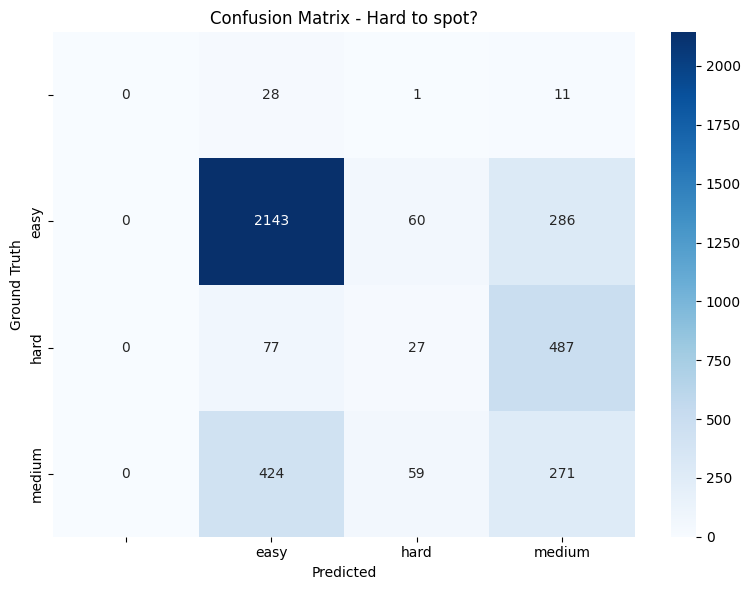

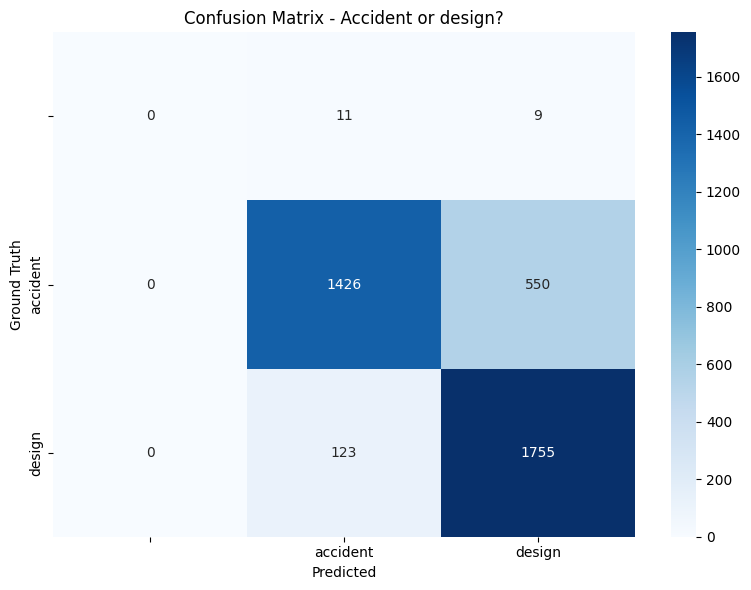

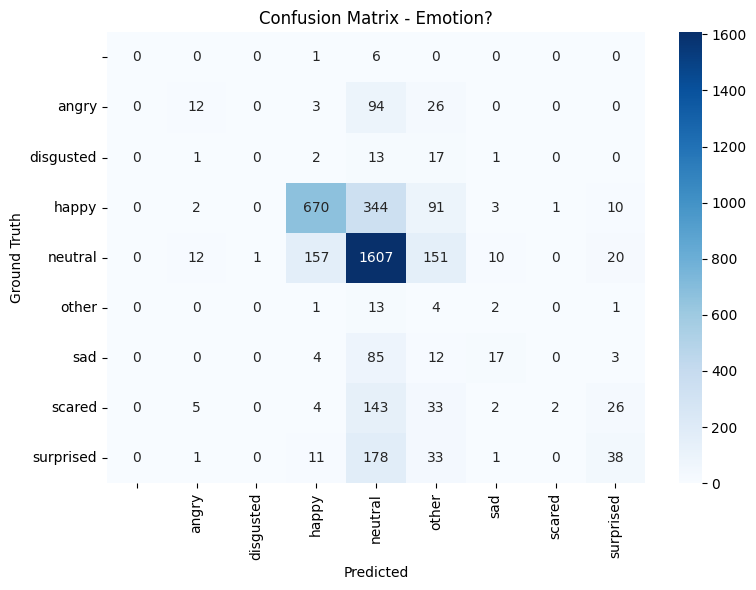

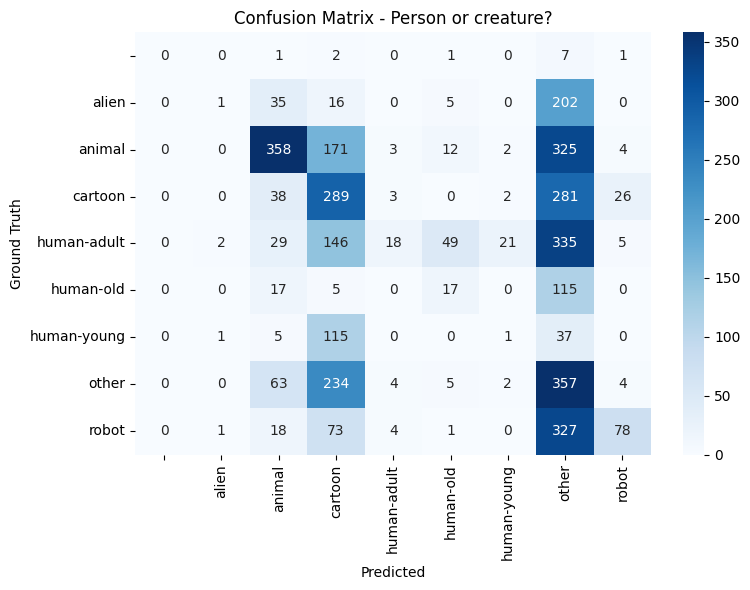

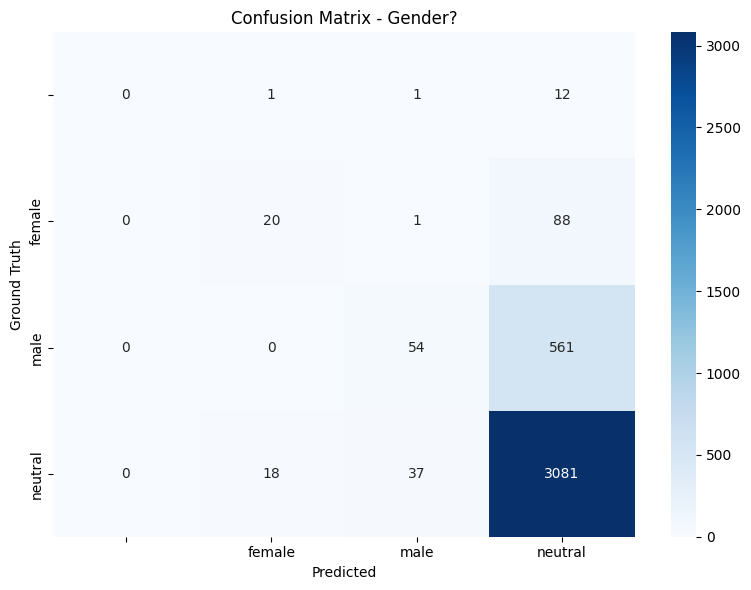

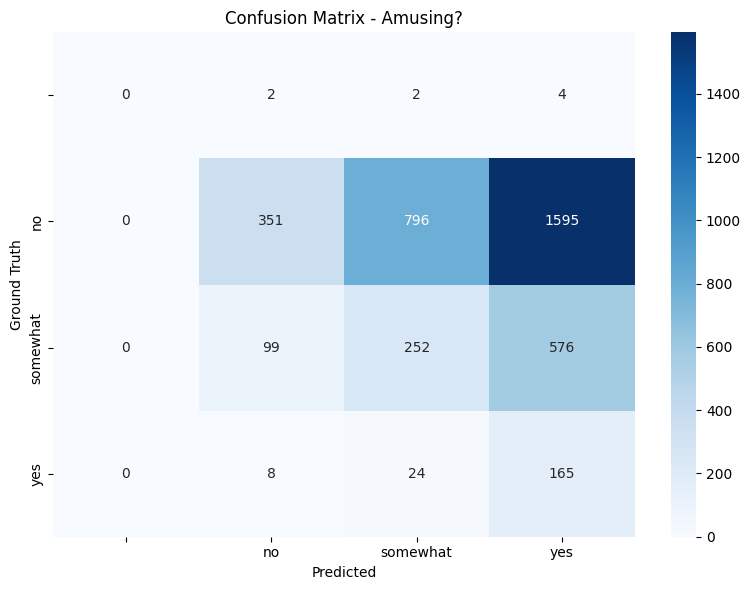

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

attributes = [
    "Hard to spot?",
    "Accident or design?",
    "Emotion?",
    "Person or creature?",
    "Gender?",
    "Amusing?"
]

for attr in attributes:
    pc, gc = f"{attr}_pred", f"{attr}_gt"
    if pc not in merged.columns or gc not in merged.columns:
        print(f"Skipping {attr} (missing columns)")
        continue

    sub = merged[[pc, gc]].dropna(how="all").copy()
    sub["pred_norm"] = sub[pc].map(normalize_value)
    sub["gt_norm"]   = sub[gc].map(normalize_value)

    y_true = sub["gt_norm"]
    y_pred = sub["pred_norm"]

    labels = sorted(set(y_true.unique()).union(set(y_pred.unique())))
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - {attr}")
    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
    plt.tight_layout()
    plt.show()


In [20]:
from sklearn.metrics import accuracy_score, f1_score

attributes = [
    "Hard to spot?",
    "Accident or design?",
    "Emotion?",
    "Person or creature?",
    "Gender?",
    "Amusing?"
]

summary = []

for attr in attributes:
    pc, gc = f"{attr}_pred", f"{attr}_gt"
    if pc not in merged.columns or gc not in merged.columns:
        print(f"Skipping {attr} (missing columns)")
        continue

    sub = merged[[pc, gc]].dropna(how="all").copy()
    sub["pred_norm"] = sub[pc].map(normalize_value)
    sub["gt_norm"]   = sub[gc].map(normalize_value)

    y_true = sub["gt_norm"]
    y_pred = sub["pred_norm"]

    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)
    weighted_f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    summary.append({
        "Attribute": attr,
        "Accuracy": round(acc, 4),
        "Macro-F1": round(macro_f1, 4),
        "Weighted-F1": round(weighted_f1, 4)
    })

summary_df = pd.DataFrame(summary).sort_values("Macro-F1", ascending=False)
display(summary_df)


,Attribute,Accuracy,Macro-F1,Weighted-F1
1,Accident or design?,0.8211,0.5480,0.8173
4,Gender?,0.8144,0.3297,0.7571
0,Hard to spot?,0.6301,0.3008,0.6030
2,Emotion?,0.6066,0.2236,0.5894
3,Person or creature?,0.2888,0.1749,0.2632
5,Amusing?,0.1982,0.1503,0.2221


,Attribute,Accuracy,Macro-F1,Micro-F1,Weighted-F1,N
1,Accident or design?,0.8211,0.5480,0.8211,0.8173,3874
4,Gender?,0.8144,0.3297,0.8144,0.7571,3874
0,Hard to spot?,0.6301,0.3008,0.6301,0.6030,3874
2,Emotion?,0.6066,0.2236,0.6066,0.5894,3874
3,Person or creature?,0.2888,0.1749,0.2888,0.2632,3874
5,Amusing?,0.1982,0.1503,0.1982,0.2221,3874


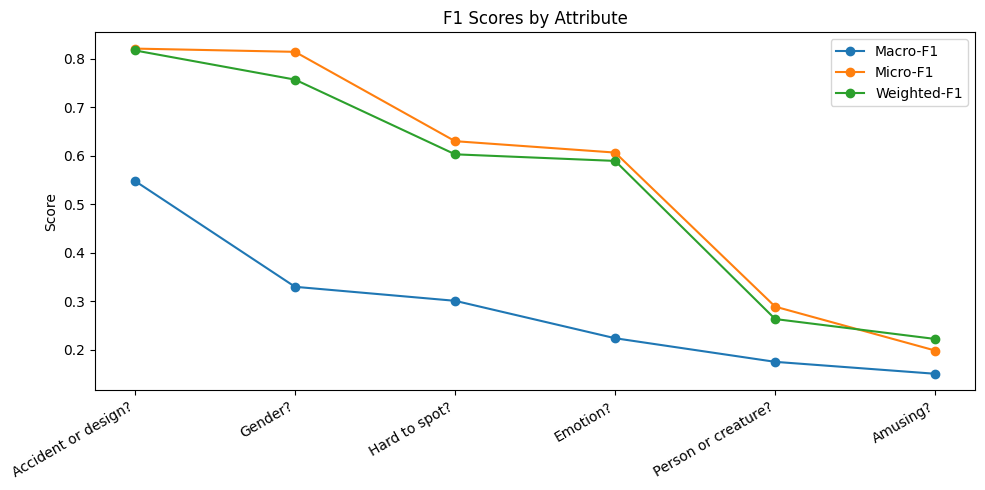

In [21]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

attributes = [
    "Hard to spot?",
    "Accident or design?",
    "Emotion?",
    "Person or creature?",
    "Gender?",
    "Amusing?"
]

summary = []

for attr in attributes:
    pc, gc = f"{attr}_pred", f"{attr}_gt"
    if pc not in merged.columns or gc not in merged.columns:
        print(f"Skipping {attr} (missing columns)")
        continue

    sub = merged[[pc, gc]].dropna(how="all").copy()
    sub["pred_norm"] = sub[pc].map(normalize_value)
    sub["gt_norm"]   = sub[gc].map(normalize_value)

    y_true = sub["gt_norm"]
    y_pred = sub["pred_norm"]

    acc = accuracy_score(y_true, y_pred)
    macro_f1   = f1_score(y_true, y_pred, average="macro", zero_division=0)
    weighted_f1= f1_score(y_true, y_pred, average="weighted", zero_division=0)
    micro_f1   = f1_score(y_true, y_pred, average="micro", zero_division=0)

    summary.append({
        "Attribute": attr,
        "Accuracy": round(acc, 4),
        "Macro-F1": round(macro_f1, 4),
        "Micro-F1": round(micro_f1, 4),
        "Weighted-F1": round(weighted_f1, 4),
        "N": len(sub)
    })

summary_df = pd.DataFrame(summary).sort_values("Macro-F1", ascending=False)
display(summary_df)

# Bar plot for Macro-F1 vs Micro-F1 vs Weighted-F1
plt.figure(figsize=(10, 5))
x = range(len(summary_df))
plt.plot(x, summary_df["Macro-F1"], marker="o", label="Macro-F1")
plt.plot(x, summary_df["Micro-F1"], marker="o", label="Micro-F1")
plt.plot(x, summary_df["Weighted-F1"], marker="o", label="Weighted-F1")
plt.xticks(x, summary_df["Attribute"], rotation=30, ha="right")
plt.ylabel("Score")
plt.title("F1 Scores by Attribute")
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
from sklearn.metrics import confusion_matrix
import numpy as np

def top_confusions_for_attribute(df, attr, k=5):
    pc, gc = f"{attr}_pred", f"{attr}_gt"
    if pc not in df.columns or gc not in df.columns:
        return pd.DataFrame(columns=["Attribute","GT","Pred","Count"])
    sub = df[[pc, gc]].dropna(how="all").copy()
    sub["pred_norm"] = sub[pc].map(normalize_value)
    sub["gt_norm"]   = sub[gc].map(normalize_value)

    y_true = sub["gt_norm"]
    y_pred = sub["pred_norm"]

    labels = sorted(set(y_true.unique()).union(set(y_pred.unique())))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    # zero out diagonal to focus on mistakes
    off_diag = cm.copy().astype(np.int64)
    np.fill_diagonal(off_diag, 0)

    rows = []
    for i, gt_lbl in enumerate(labels):
        for j, pr_lbl in enumerate(labels):
            c = int(off_diag[i, j])
            if c > 0:
                rows.append((attr, gt_lbl, pr_lbl, c))
    rows.sort(key=lambda x: x[3], reverse=True)
    top = rows[:k]
    return pd.DataFrame(top, columns=["Attribute","GT","Pred","Count"])

# Collect top confusions for all attributes
all_tops = []
for attr in attributes:
    df_top = top_confusions_for_attribute(merged, attr, k=5)
    if len(df_top):
        all_tops.append(df_top)

top_confusions_df = pd.concat(all_tops, ignore_index=True) if all_tops else pd.DataFrame(columns=["Attribute","GT","Pred","Count"])
display(top_confusions_df)


,Attribute,GT,Pred,Count
0,Hard to spot?,hard,medium,487
1,Hard to spot?,medium,easy,424
2,Hard to spot?,easy,medium,286
3,Hard to spot?,hard,easy,77
4,Hard to spot?,easy,hard,60
5,Accident or design?,accident,design,550
6,Accident or design?,design,accident,123
7,Accident or design?,,accident,11
8,Accident or design?,,design,9
9,Emotion?,happy,neutral,344


In [23]:
error_profiles = []

for attr in attributes:
    pc, gc = f"{attr}_pred", f"{attr}_gt"
    if pc not in merged.columns or gc not in merged.columns:
        continue

    sub = merged[[pc, gc]].dropna(how="all").copy()
    sub["pred_norm"] = sub[pc].map(normalize_value)
    sub["gt_norm"]   = sub[gc].map(normalize_value)

    gt_counts   = sub["gt_norm"].value_counts()
    pred_counts = sub["pred_norm"].value_counts()
    tp_counts   = (sub["pred_norm"] == sub["gt_norm"]).groupby(sub["gt_norm"]).sum()

    classes = sorted(set(gt_counts.index).union(set(pred_counts.index)))
    for cls in classes:
        tp = int(tp_counts.get(cls, 0))
        fp = int(pred_counts.get(cls, 0)) - tp
        fn = int(gt_counts.get(cls, 0)) - tp
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        if precision < 0.3 and recall > 0.3:
            category = "Overpredict"
        elif recall < 0.3 and precision > 0.3:
            category = "Underpredict"
        elif recall < 0.05 and precision < 0.05:
            category = "Collapse"
        else:
            category = "Balanced/OK"

        error_profiles.append({
            "Attribute": attr,
            "Class": cls,
            "Precision": round(precision, 3),
            "Recall": round(recall, 3),
            "Error_Profile": category,
            "Support(GT)": int(gt_counts.get(cls, 0)),
            "Pred_Count": int(pred_counts.get(cls, 0))
        })

error_df = pd.DataFrame(error_profiles)
display(error_df.sort_values(["Attribute","Error_Profile"]))


,Attribute,Class,Precision,Recall,Error_Profile,Support(GT),Pred_Count
5,Accident or design?,accident,0.914,0.722,Balanced/OK,1976,1560
6,Accident or design?,design,0.758,0.935,Balanced/OK,1878,2314
4,Accident or design?,,0.000,0.000,Collapse,20,0
31,Amusing?,somewhat,0.235,0.272,Balanced/OK,927,1074
29,Amusing?,,0.000,0.000,Collapse,8,0
32,Amusing?,yes,0.071,0.838,Overpredict,197,2340
30,Amusing?,no,0.763,0.128,Underpredict,2742,460
10,Emotion?,happy,0.785,0.598,Balanced/OK,1121,853
11,Emotion?,neutral,0.647,0.821,Balanced/OK,1958,2483
12,Emotion?,other,0.011,0.190,Balanced/OK,21,367


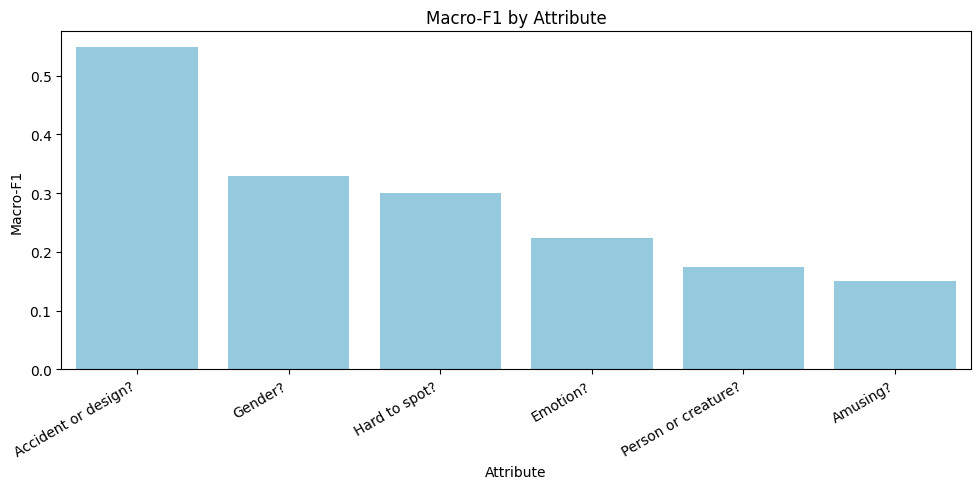

In [24]:
plt.figure(figsize=(10,5))
sns.barplot(data=summary_df, x="Attribute", y="Macro-F1", color="skyblue")
plt.xticks(rotation=30, ha="right")
plt.title("Macro-F1 by Attribute")
plt.tight_layout()
plt.show()


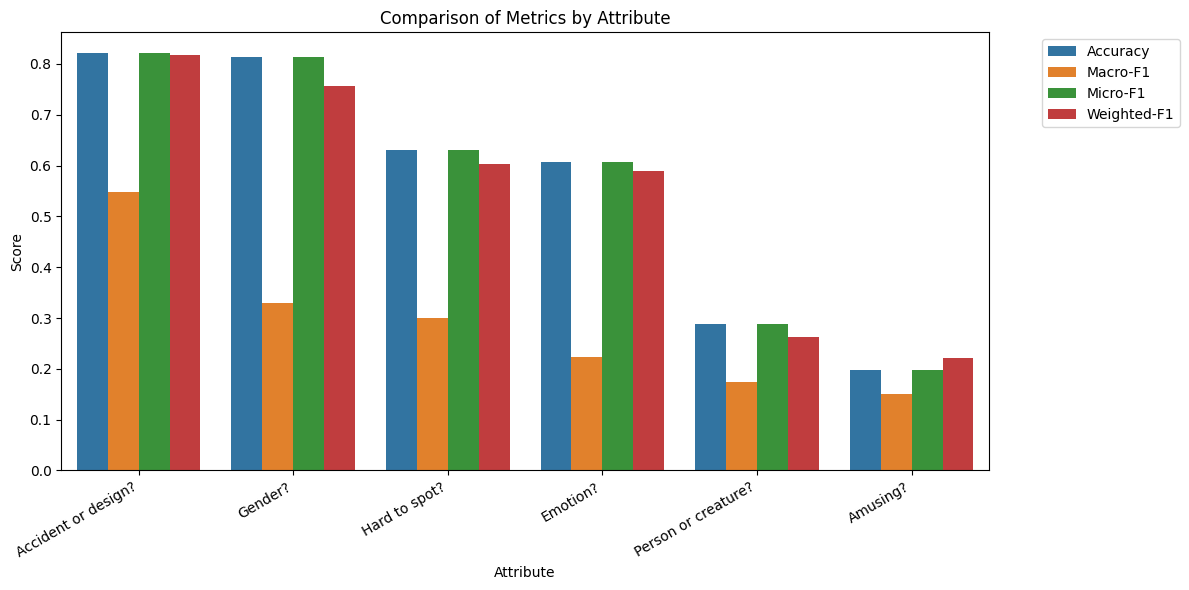

In [25]:
summary_melt = summary_df.melt(id_vars=["Attribute"], 
                               value_vars=["Accuracy","Macro-F1","Micro-F1","Weighted-F1"],
                               var_name="Metric", value_name="Score")

plt.figure(figsize=(12,6))
sns.barplot(data=summary_melt, x="Attribute", y="Score", hue="Metric")
plt.xticks(rotation=30, ha="right")
plt.title("Comparison of Metrics by Attribute")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()
